In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
import ast
from datetime import datetime
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from sklearn.preprocessing import MultiLabelBinarizer
import warnings

# Suppress expected warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.cluster._supervised')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_selection')

def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

def calculate_token_lengths(texts, tokenizer):
    """
    Calculate the token length for each text sample using the specified tokenizer.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        
    Returns:
        pd.Series: Series containing the token length of each text
    """
    token_lengths = []
    for text in tqdm(texts, desc="Calculating token lengths"):
        if pd.isna(text) or text == '':
            token_lengths.append(0)
        else:
            tokens = tokenizer(str(text), truncation=False, return_tensors="pt")["input_ids"][0]
            token_lengths.append(len(tokens))
    
    return pd.Series(token_lengths, index=texts.index)

def filter_outliers_by_token_length(texts, token_lengths, std_threshold=3.0, min_token_threshold=None):
    """
    Filter out text samples with token lengths beyond a certain standard deviation threshold.
    
    Args:
        texts (pd.Series): Series of input texts
        token_lengths (pd.Series): Series containing token length of each text
        std_threshold (float): Standard deviation threshold (default: 3.0)
        min_token_threshold (int, optional): Minimum number of tokens required (default: None)
        
    Returns:
        tuple: Filtered texts and boolean mask to apply to original data
    """
    mean_length = token_lengths.mean()
    std_length = token_lengths.std()
    
    # Print original token statistics
    print(f"Token length statistics before filtering:")
    print(f"  Mean: {mean_length:.2f}, Std Dev: {std_length:.2f}")
    print(f"  Min: {token_lengths.min()}, Max: {token_lengths.max()}")
    print(f"  25th percentile: {token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {token_lengths.quantile(0.75):.2f}")
    
    # Original data size
    original_size = len(texts)
    
    # Start with all True mask for the original data
    final_mask = pd.Series(True, index=texts.index)
    
    # Step 1: Apply standard deviation filtering if std_threshold is provided
    if std_threshold < float('inf'):
        upper_bound = mean_length + std_threshold * std_length
        lower_bound = mean_length - std_threshold * std_length
        std_mask = (token_lengths >= lower_bound) & (token_lengths <= upper_bound)
        
        removed_by_std = (~std_mask).sum()
        print(f"Removing {removed_by_std} samples ({removed_by_std/original_size*100:.2f}%) based on {std_threshold} std dev threshold")
        print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
        
        final_mask = final_mask & std_mask
    
    # Step 2: Apply minimum token threshold if specified
    if min_token_threshold is not None:
        min_mask = token_lengths >= min_token_threshold
        removed_by_min = (~min_mask).sum()
        print(f"Removing {removed_by_min} samples ({removed_by_min/original_size*100:.2f}%) with < {min_token_threshold} tokens")
        
        final_mask = final_mask & min_mask
    
    # Apply final mask to get filtered data
    filtered_texts = texts[final_mask]
    filtered_token_lengths = token_lengths[final_mask]
    
    # Calculate total removed
    total_removed = (~final_mask).sum()
    print(f"Total removed: {total_removed} samples ({total_removed/original_size*100:.2f}% of original data)")
    print(f"Remaining: {final_mask.sum()} samples ({final_mask.sum()/original_size*100:.2f}% of original data)")

    # Print final statistics
    print(f"\nToken length statistics after all filtering:")
    print(f"  Mean: {filtered_token_lengths.mean():.2f}, Std Dev: {filtered_token_lengths.std():.2f}")
    print(f"  Min: {filtered_token_lengths.min()}, Max: {filtered_token_lengths.max()}")
    print(f"  25th percentile: {filtered_token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {filtered_token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {filtered_token_lengths.quantile(0.75):.2f}")
    
    return filtered_texts, final_mask

class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, model, label_encoder=None, max_length=512):
        """
        Args:
            texts: pandas Series or list of texts
            labels: list of label lists
            model: SBERT model
            label_encoder: MultiLabelBinarizer instance (optional)
            max_length: maximum sequence length
        """
        # Convert texts to list if it's a pandas Series
        self.texts = texts.tolist() if isinstance(texts, pd.Series) else texts
        
        # Initialize or use provided label encoder
        if label_encoder is None:
            self.label_encoder = MultiLabelBinarizer()
            self.labels = self.label_encoder.fit_transform(labels)
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(labels)
        
        self.model = model
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]  # Now a binary numpy array
        
        # Handle DataParallel wrapped model
        actual_model = self.model.module if hasattr(self.model, 'module') else self.model
        
        encoding = actual_model._first_module().tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float)
        }

class FineTunedSBERT(SentenceTransformer):
    def __init__(self, model_name='all-mpnet-base-v2', num_labels=20):
        super().__init__(model_name)
        for param in self.parameters():
            param.requires_grad = False
        
        for layer in self._first_module().auto_model.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        for param in self._first_module().auto_model.pooler.parameters():
            param.requires_grad = True
            
        hidden_size = self._first_module().auto_model.config.hidden_size
        self.classifier = torch.nn.Linear(hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self._first_module().auto_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, tokenizer=None, token_std_threshold=None, min_token_threshold=None):
    """
    Prepare data with optional token length filtering.
    
    Args:
        df: DataFrame with text and labels
        text_column: Name of the text column
        min_label_freq: Minimum frequency for labels to be kept
        max_label_len: Maximum number of labels per sample
        tokenizer: Tokenizer for token length calculation (optional)
        token_std_threshold: Standard deviation threshold for token filtering (optional)
        min_token_threshold: Minimum number of tokens required (optional)
    
    Returns:
        tuple: (texts, filtered_labels)
    """
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame")
    
    df = df.dropna()
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])

    print(f"Initial data size: {len(texts)} samples")

    # Apply token length filtering if tokenizer is provided
    if tokenizer is not None and (token_std_threshold is not None or min_token_threshold is not None):
        print(f"\nApplying token length filtering...")
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # Convert std_threshold parameter
        std_threshold = float('inf')
        if token_std_threshold == '2std':
            std_threshold = 2.0
        elif token_std_threshold == '3std':
            std_threshold = 3.0
        elif token_std_threshold is not None:
            std_threshold = float(token_std_threshold)
            
        # Filter by token length, keeping track of the mask
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=std_threshold,
            min_token_threshold=min_token_threshold
        )
        
        # Apply the same mask to labels
        filtered_labels_by_token = labels[token_mask]
        
        # Reset indices for further processing
        texts = filtered_texts.reset_index(drop=True)
        labels = filtered_labels_by_token.reset_index(drop=True)
        
        print(f"After token filtering: {len(texts)} samples")

    # Apply label frequency filtering
    label_distribution = Counter([label for labels in labels for label in labels])
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    
    print(f"Labels with frequency >= {min_label_freq}: {len(frequent_labels)} out of {len(label_distribution)}")
    
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    print(f"Samples with 1-{max_label_len} frequent labels: {length_mask.sum()} out of {len(length_mask)}")
    
    texts = texts[length_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[length_mask].reset_index(drop=True)
    
    print(f"Final data size: {len(texts)} samples")
    
    return texts, filtered_labels

def get_embeddings(texts, model, batch_size=32):
    model.eval()
    embeddings = []
    device = next(model.parameters()).device
    
    # Handle DataParallel wrapped model
    actual_model = model.module if hasattr(model, 'module') else model
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i + batch_size].tolist()
            
            encoding = actual_model._first_module().tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            outputs = actual_model._first_module().auto_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            
            embeddings.append(pooled_output.cpu().numpy())
    
    return np.vstack(embeddings)

def find_similar_requests(test_embeddings, train_embeddings, train_labels, top_k=5):
    """
    Find similar requests using cosine similarity.
    
    Args:
        test_embeddings: numpy array of shape (n_test, embedding_dim)
        train_embeddings: numpy array of shape (n_train, embedding_dim)
        train_labels: list of label lists
        top_k: number of similar items to retrieve
    """
    similarities = cosine_similarity(test_embeddings, train_embeddings)
    similar_indices = []
    similarity_scores = []
    
    for i in range(len(test_embeddings)):
        # Get indices of top-k similar items
        top_indices = np.argsort(similarities[i])[-top_k:][::-1]
        similar_indices.append(top_indices)
        similarity_scores.append(similarities[i][top_indices])
    
    return similar_indices, similarity_scores

def train_sbert_epoch(model, train_loader, criterion, optimizer, device, gradient_accumulation_steps=4, early_stopping=None):
    """
    Train SBERT for one epoch with optional early stopping.
    
    Args:
        model: SBERT model
        train_loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device (CPU/GPU)
        gradient_accumulation_steps: Steps for gradient accumulation
        early_stopping: EarlyStopping instance (optional)
    
    Returns:
        tuple: (average_loss, early_stop_triggered)
    """
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    if (i + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(train_loader)
    
    # Check for early stopping
    early_stop_triggered = False
    if early_stopping:
        early_stopping(avg_loss)
        early_stop_triggered = early_stopping.early_stop
    
    return avg_loss, early_stop_triggered

def validate_sbert(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return total_loss / len(val_loader)

def calculate_label_based_metrics(test_labels, train_labels, similar_indices, k_values=[1, 3, 5]):
    """
    Calculate precision@k, recall@k, F1@k and other metrics based on label matching.
    
    Args:
        test_labels: list of label lists
        train_labels: list of label lists
        similar_indices: list of arrays containing indices of similar items
        k_values: list of k values for precision@k, recall@k, and F1@k
    """
    metrics = {f'precision@{k}': [] for k in k_values}
    metrics.update({f'recall@{k}': [] for k in k_values})
    metrics.update({f'f1@{k}': [] for k in k_values})
    metrics.update({
        'avg_label_overlap': [],
        'total_matches': 0,
        'total_test_samples': len(test_labels)
    })
    
    for i, test_label_set in enumerate(test_labels):
        test_labels_set = set(test_label_set)
        retrieved_indices = similar_indices[i]
        
        matches_at_k = [0] * len(k_values)
        recall_at_k = [set() for _ in k_values]
        label_overlaps = []
        
        for j, idx in enumerate(retrieved_indices):
            train_labels_set = set(train_labels[idx])
            matching_labels = test_labels_set & train_labels_set  # Intersection
            
            if matching_labels:  # If there are matching labels
                for k_idx, k in enumerate(k_values):
                    if j < k:
                        matches_at_k[k_idx] += 1
                        recall_at_k[k_idx].update(matching_labels)
                
                overlap = len(matching_labels) / len(test_labels_set | train_labels_set)
                label_overlaps.append(overlap)
        
        for k_idx, k in enumerate(k_values):
            # Precision@k - proportion of retrieved items that are relevant
            precision_at_k = matches_at_k[k_idx] / k if k > 0 else 0
            metrics[f'precision@{k}'].append(precision_at_k)
            
            # Recall@k - proportion of relevant items that are retrieved
            recall = len(recall_at_k[k_idx]) / len(test_labels_set) if test_labels_set else 0
            metrics[f'recall@{k}'].append(recall)
            
            # F1@k - harmonic mean of precision and recall
            if precision_at_k + recall > 0:
                f1 = 2 * precision_at_k * recall / (precision_at_k + recall)
            else:
                f1 = 0
            metrics[f'f1@{k}'].append(f1)
        
        avg_overlap = np.mean(label_overlaps) if label_overlaps else 0
        metrics['avg_label_overlap'].append(avg_overlap)
        
        if any(matches_at_k):
            metrics['total_matches'] += 1
    
    # Calculate average metrics
    for k in k_values:
        metrics[f'avg_precision@{k}'] = np.mean(metrics[f'precision@{k}'])
        metrics[f'avg_recall@{k}'] = np.mean(metrics[f'recall@{k}'])
        metrics[f'avg_f1@{k}'] = np.mean(metrics[f'f1@{k}'])
    
    metrics['avg_label_overlap'] = np.mean(metrics['avg_label_overlap'])
    metrics['match_rate'] = metrics['total_matches'] / metrics['total_test_samples']
    
    return metrics

def plot_precision_at_k(metrics, k_values, run_dir):
    """
    Plot precision@k, recall@k, and F1@k values.
    """
    plt.figure(figsize=(12, 8))
    
    avg_precisions = [metrics[f'avg_precision@{k}'] for k in k_values]
    avg_recalls = [metrics[f'avg_recall@{k}'] for k in k_values]
    avg_f1s = [metrics[f'avg_f1@{k}'] for k in k_values]
    
    plt.plot(k_values, avg_precisions, marker='o', label='Precision@k')
    plt.plot(k_values, avg_recalls, marker='s', label='Recall@k')
    plt.plot(k_values, avg_f1s, marker='^', label='F1@k')
    
    plt.title('Evaluation Metrics at Different k Values')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Still save the figure for later reference
    plt.savefig(os.path.join(run_dir, 'metrics_at_k.png'))
    plt.close()

def create_stratification_labels(labels_list, min_samples_per_label=2):
    """
    Create stratification labels that ensure each label has enough samples.
    Only considers labels that appear frequently enough for stratification.
    """
    # Count label occurrences
    label_counts = Counter([label for labels in labels_list for label in labels])
    
    # Keep only labels that appear frequently enough
    frequent_labels = {label for label, count in label_counts.items() if count >= min_samples_per_label}
    
    # Create binary indicators only for frequent labels
    stratification_indicators = []
    for labels in labels_list:
        # Create indicator only for frequent labels
        indicator = tuple(sorted(label for label in labels if label in frequent_labels))
        # If no frequent labels, use a special category
        if not indicator:
            indicator = ('rare_combination',)
        stratification_indicators.append(indicator)
    
    return stratification_indicators

def main(args):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Check available GPUs
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus > 1:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    print(f"Loading data from {args.data_path}...")
    df = pd.read_csv(args.data_path)
    
    # Convert labels column from string representation to actual lists if needed
    if 'labels' in df.columns:
        first_label = df['labels'].iloc[0]
        if isinstance(first_label, str) and not first_label.startswith('['):
            # Handle comma-separated string labels
            print("Converting comma-separated labels to lists...")
            df['labels'] = df['labels'].apply(lambda x: [label.strip() for label in str(x).split(',')] if pd.notna(x) and str(x).strip() != '' else [])
        elif isinstance(first_label, str) and first_label.startswith('['):
            # Handle string representation of lists (e.g., "['label1', 'label2']")
            print("Converting labels from string format to lists...")
            def safe_eval(x):
                try:
                    if pd.notna(x) and str(x).strip() not in ['', '[]']:
                        return ast.literal_eval(x)
                    return []
                except (ValueError, SyntaxError):
                    return []
            df['labels'] = df['labels'].apply(safe_eval)
        # If labels are already lists, no conversion needed
    
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Initialize SBERT model first to get tokenizer for token filtering
    print("\nInitializing SBERT model...")
    model = FineTunedSBERT('all-mpnet-base-v2', num_labels=20)  # Temporary, will be updated
    model.max_seq_length = 512
    model.use_fast_tokenizer = True
    
    # Apply multi-GPU setup
    model = model.to(device)
    if use_multi_gpu:
        model = torch.nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Get tokenizer for token length filtering
    # Handle DataParallel wrapped model
    if hasattr(model, 'module'):
        tokenizer = model.module._first_module().tokenizer
    else:
        tokenizer = model._first_module().tokenizer
    
    # Prepare data with optional token filtering
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len,
        tokenizer=tokenizer if args.token_std_threshold or args.min_token_threshold else None,
        token_std_threshold=args.token_std_threshold,
        min_token_threshold=args.min_token_threshold
    )
    
    # Initialize label encoder with all labels first
    print("\nInitializing label encoder...")
    mlb = MultiLabelBinarizer()
    mlb.fit(filtered_labels)
    print(f"Number of unique labels: {len(mlb.classes_)}")
    print("Labels:", mlb.classes_)
    
    # Reinitialize SBERT model with correct number of labels
    print("\nReinitializing SBERT model with correct label count...")
    model = FineTunedSBERT('all-mpnet-base-v2', num_labels=len(mlb.classes_))
    model.max_seq_length = 512
    model.use_fast_tokenizer = True
    
    # Apply multi-GPU setup again
    model = model.to(device)
    if use_multi_gpu:
        model = torch.nn.DataParallel(model)
        print("Reinitialized model wrapped in DataParallel")
    
    # Create stratification indicators
    print("\nPreparing stratified split...")
    stratification_indicators = create_stratification_labels(filtered_labels)
    
    try:
        # Try stratified split and convert to lists
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42,
            stratify=stratification_indicators
        )
        
        # Use indices to split both texts and labels
        train_texts = texts.iloc[train_indices].reset_index(drop=True)
        test_texts = texts.iloc[test_indices].reset_index(drop=True)
        train_labels = [filtered_labels[i] for i in train_indices]
        test_labels = [filtered_labels[i] for i in test_indices]
        
        print("Successfully performed stratified split")
    except ValueError as e:
        print(f"Warning: Could not perform stratified split ({str(e)})")
        print("Falling back to random split")
        
        # Random split with indices
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42
        )
        
        # Use indices to split both texts and labels
        train_texts = texts.iloc[train_indices].reset_index(drop=True)
        test_texts = texts.iloc[test_indices].reset_index(drop=True)
        train_labels = [filtered_labels[i] for i in train_indices]
        test_labels = [filtered_labels[i] for i in test_indices]

    # Print split statistics
    train_label_dist = Counter([label for labels in train_labels for label in labels])
    test_label_dist = Counter([label for labels in test_labels for label in labels])
    
    print("\nLabel distribution in splits:")
    all_labels = sorted(set(train_label_dist.keys()) | set(test_label_dist.keys()))
    print("\nLabel          Train  Test")
    print("-" * 30)
    for label in all_labels:
        train_count = train_label_dist.get(label, 0)
        test_count = test_label_dist.get(label, 0)
        print(f"{label[:10]:12} {train_count:5d} {test_count:5d}")

    print(f"\nTotal samples - Training: {len(train_texts)}, Testing: {len(test_texts)}")
    
    # Create datasets with shared label encoder
    train_dataset = MultiLabelDataset(train_texts, train_labels, model, label_encoder=mlb)
    test_dataset = MultiLabelDataset(test_texts, test_labels, model, label_encoder=mlb)
    
    # Create data loaders with batch size scaling for multi-GPU
    batch_size = args.batch_size
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    effective_batch_size = batch_size // 4
    gradient_accumulation_steps = 4
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=effective_batch_size,
        shuffle=True,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=effective_batch_size,
        num_workers=0
    )
    
    # Fine-tune SBERT if specified
    if args.training_epochs > 0:
        criterion = BCEWithLogitsLoss()
        optimizer = AdamW(model.parameters(), lr=2e-5)
        
        best_loss = float('inf')
        train_losses = []
        test_losses = []
        
        print(f"\nStarting SBERT fine-tuning for {args.training_epochs} epochs...")
        
        # Initialize early stopping with configurable parameters
        patience = getattr(args, 'patience', 3)
        early_stopping = EarlyStopping(patience=patience, min_delta=0.0001)
        
        for epoch in range(args.training_epochs):
            print(f"\nEpoch {epoch+1}/{args.training_epochs}")
            
            # Train epoch and get potential early stop signal
            train_loss, train_early_stop = train_sbert_epoch(
                model, train_loader, criterion, optimizer, device, gradient_accumulation_steps, early_stopping
            )
            
            test_loss = validate_sbert(
                model, test_loader, criterion, device
            )
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Test Loss: {test_loss:.4f}")
            
            # Early stopping check based on validation loss
            early_stopping(test_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered after {epoch+1} epochs (patience: {patience})")
                break
            
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), os.path.join(run_dir, 'best_sbert_model.pt'))
                print("Saved new best model")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Training and Test Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(run_dir, 'training_curves.png'))
        plt.close()
        
        # Load best model for generating embeddings
        model.load_state_dict(torch.load(os.path.join(run_dir, 'best_sbert_model.pt')))
    
    model.eval()
    
    # Generate embeddings for training and testing sets
    print("\nGenerating embeddings with model...")
    train_embeddings = get_embeddings(train_texts, model, batch_size=args.batch_size)
    test_embeddings = get_embeddings(test_texts, model, batch_size=args.batch_size)
    
    # Find similar requests for each test sample
    print("\nFinding similar requests...")
    similar_indices, similarity_scores = find_similar_requests(
        test_embeddings, train_embeddings, train_labels, top_k=args.top_k
    )
    
    # Calculate label-based metrics
    print("\nCalculating label-based metrics...")
    k_values = [1, 3, 5, 10]  # Calculate precision@1, @3, @5, @10
    label_metrics = calculate_label_based_metrics(test_labels, train_labels, similar_indices, k_values)
    
    # Print metrics
    print("\nLabel-based Metrics:")
    print(f"Match Rate (at least one match): {label_metrics['match_rate']:.4f}")
    for k in k_values:
        print(f"Average Precision@{k}: {label_metrics[f'avg_precision@{k}']:.4f}")
        print(f"Average Recall@{k}: {label_metrics[f'avg_recall@{k}']:.4f}")
        print(f"Average F1@{k}: {label_metrics[f'avg_f1@{k}']:.4f}")
    print(f"Average Label Overlap: {label_metrics['avg_label_overlap']:.4f}")
    
    # Plot metrics@k
    plot_precision_at_k(label_metrics, k_values, run_dir)
    
    # Save results
    results = {
        'text_column': args.text_column,
        'similar_requests': {
            'indices': [indices.tolist() for indices in similar_indices],
            'scores': [scores.tolist() for scores in similarity_scores]
        },
        'label_metrics': label_metrics,
        'sbert_training': {
            'train_losses': train_losses if args.training_epochs > 0 else [],
            'test_losses': test_losses if args.training_epochs > 0 else [],
            'best_loss': float(best_loss) if args.training_epochs > 0 else None
        }
    }
    
    # Save detailed similarity results with label matching information
    similarity_results = []
    for i, (indices, scores) in enumerate(zip(similar_indices, similarity_scores)):
        test_sample = {
            'test_text': test_texts.iloc[i],
            'test_labels': test_labels[i],
            'similar_requests': []
        }
        
        test_labels_set = set(test_labels[i])
        for j, (idx, score) in enumerate(zip(indices, scores)):
            train_labels_set = set(train_labels[idx])
            matching_labels = list(test_labels_set & train_labels_set)
            
            similar_request = {
                'rank': j + 1,
                'text': train_texts.iloc[idx],
                'labels': train_labels[idx],
                'similarity_score': float(score),
                'matching_labels': matching_labels,
                'has_matching_label': len(matching_labels) > 0
            }
            test_sample['similar_requests'].append(similar_request)
        
        similarity_results.append(test_sample)
    
    with open(os.path.join(run_dir, 'similarity_results.json'), 'w') as f:
        json.dump(similarity_results, f, indent=4)
    
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\nAnalysis completed! Results saved to {run_dir}")
    
    return {
        'model': model,
        'train_embeddings': train_embeddings,
        'test_embeddings': test_embeddings,
        'similar_indices': similar_indices,
        'similarity_scores': similarity_scores,
        'label_metrics': label_metrics,
        'results_dir': run_dir
    }

2025-06-01 17:48:37.370179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748800117.594669      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748800117.661520      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# No Fine Tuning

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/feature-data-comments-without-filename/preprocessed_feature_data_0.9.csv...
Converting labels from string format to lists...

Initializing SBERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model wrapped in DataParallel
Initial data size: 865 samples

Applying token length filtering...


Calculating token lengths: 100%|██████████| 865/865 [00:01<00:00, 612.45it/s]


Token length statistics before filtering:
  Mean: 497.32, Std Dev: 605.05
  Min: 13, Max: 11533
  25th percentile: 133.00
  50th percentile (median): 336.00
  75th percentile: 698.00
Removing 7 samples (0.81%) based on 3.0 std dev threshold
  Lower bound: -1317.83, Upper bound: 2312.48
Removing 0 samples (0.00%) with < 0 tokens
Total removed: 7 samples (0.81% of original data)
Remaining: 858 samples (99.19% of original data)

Token length statistics after all filtering:
  Mean: 467.71, Std Dev: 428.00
  Min: 13, Max: 2125
  25th percentile: 132.25
  50th percentile (median): 333.50
  75th percentile: 680.75
After token filtering: 858 samples
Labels with frequency >= 5: 20 out of 31
Samples with 1-2 frequent labels: 723 out of 858
Final data size: 723 samples

Initializing label encoder...
Number of unique labels: 19
Labels: ['area/admission-control' 'area/apiserver' 'area/cloudprovider'
 'area/code-generation' 'area/conformance' 'area/custom-resources'
 'area/dependency' 'area/e2e-test

Generating embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]



Finding similar requests...

Calculating label-based metrics...

Label-based Metrics:
Match Rate (at least one match): 0.9452
Average Precision@1: 0.7945
Average Recall@1: 0.7123
Average F1@1: 0.7397
Average Precision@3: 0.7215
Average Recall@3: 0.8288
Average F1@3: 0.7403
Average Precision@5: 0.6959
Average Recall@5: 0.8630
Average F1@5: 0.7383
Average Precision@10: 0.6630
Average Recall@10: 0.9041
Average F1@10: 0.7308
Average Label Overlap: 0.7373


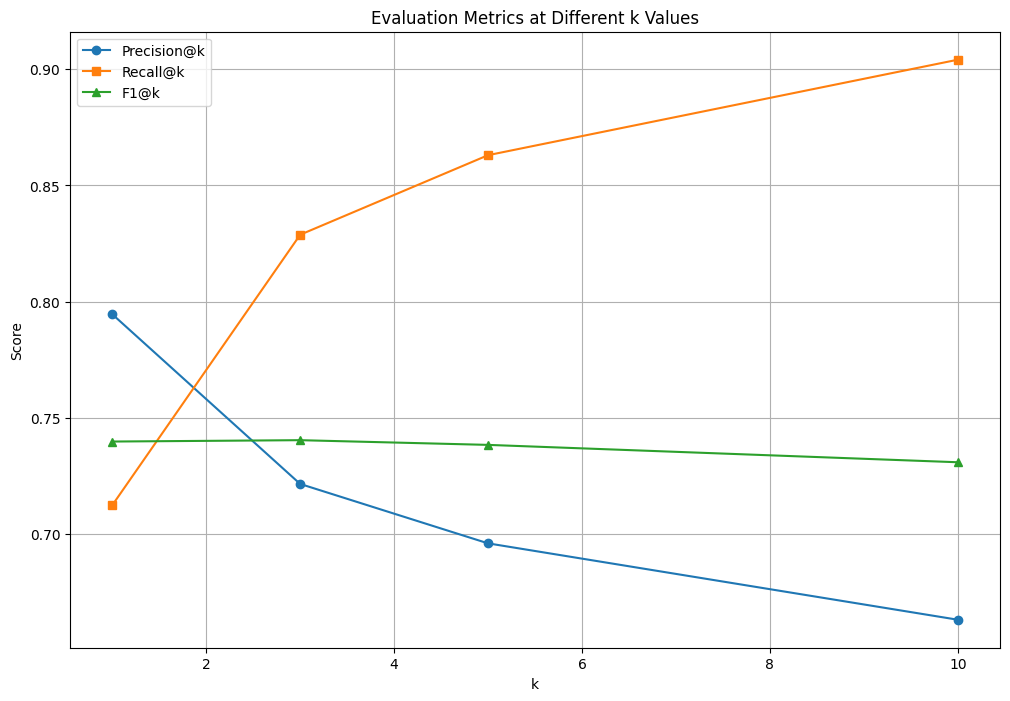


Analysis completed! Results saved to ./results/run_20250601_174853_all_text


In [2]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Compare change requests using SBERT embeddings and cosine similarity')
    
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/feature-data-comments-without-filename/preprocessed_feature_data_0.9.csv",
                        help='Path to the CSV data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample')
    
    # Token filtering parameters
    parser.add_argument('--token_std_threshold', type=float, default=3.0,
                        help='Standard deviation threshold for filtering token length outliers')
    parser.add_argument('--min_token_threshold', type=int, default=0,
                        help='Minimum token length threshold for filtering')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Batch size for generating embeddings')
    parser.add_argument('--training_epochs', type=int, default=0,
                        help='Number of epochs for SBERT fine-tuning (0 to skip)')
    parser.add_argument('--patience', type=int, default=5,
                        help='Early stopping patience (number of epochs to wait for improvement)')
    parser.add_argument('--top_k', type=int, default=10,
                        help='Number of similar requests to find for each test sample')
    
    args, unknown = parser.parse_known_args()
    results = main(args)

# Fine Tune 30 epochs

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/feature-data-comments-without-filename/preprocessed_feature_data_0.9.csv...
Converting labels from string format to lists...

Initializing SBERT model...
Model wrapped in DataParallel
Initial data size: 865 samples

Applying token length filtering...


Calculating token lengths: 100%|██████████| 865/865 [00:01<00:00, 598.39it/s]


Token length statistics before filtering:
  Mean: 497.32, Std Dev: 605.05
  Min: 13, Max: 11533
  25th percentile: 133.00
  50th percentile (median): 336.00
  75th percentile: 698.00
Removing 7 samples (0.81%) based on 3.0 std dev threshold
  Lower bound: -1317.83, Upper bound: 2312.48
Removing 0 samples (0.00%) with < 0 tokens
Total removed: 7 samples (0.81% of original data)
Remaining: 858 samples (99.19% of original data)

Token length statistics after all filtering:
  Mean: 467.71, Std Dev: 428.00
  Min: 13, Max: 2125
  25th percentile: 132.25
  50th percentile (median): 333.50
  75th percentile: 680.75
After token filtering: 858 samples
Labels with frequency >= 5: 20 out of 31
Samples with 1-2 frequent labels: 723 out of 858
Final data size: 723 samples

Initializing label encoder...
Number of unique labels: 19
Labels: ['area/admission-control' 'area/apiserver' 'area/cloudprovider'
 'area/code-generation' 'area/conformance' 'area/custom-resources'
 'area/dependency' 'area/e2e-test

Validating: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Train Loss: 0.6736
Test Loss: 0.6396
Saved new best model

Epoch 2/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.6201
Test Loss: 0.5849
Saved new best model

Epoch 3/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Train Loss: 0.5707
Test Loss: 0.5387
Saved new best model

Epoch 4/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Train Loss: 0.5285
Test Loss: 0.4996
Saved new best model

Epoch 5/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Train Loss: 0.4923
Test Loss: 0.4647
Saved new best model

Epoch 6/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Train Loss: 0.4584
Test Loss: 0.4316
Saved new best model

Epoch 7/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Train Loss: 0.4259
Test Loss: 0.4000
Saved new best model

Epoch 8/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Train Loss: 0.3947
Test Loss: 0.3703
Saved new best model

Epoch 9/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Train Loss: 0.3658
Test Loss: 0.3431
Saved new best model

Epoch 10/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Train Loss: 0.3397
Test Loss: 0.3186
Saved new best model

Epoch 11/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Train Loss: 0.3156
Test Loss: 0.2973
Saved new best model

Epoch 12/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.2952
Test Loss: 0.2790
Saved new best model

Epoch 13/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Train Loss: 0.2776
Test Loss: 0.2638
Saved new best model

Epoch 14/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.2625
Test Loss: 0.2512
Saved new best model

Epoch 15/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.2506
Test Loss: 0.2409
Saved new best model

Epoch 16/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.2402
Test Loss: 0.2326
Saved new best model

Epoch 17/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.2324
Test Loss: 0.2258
Saved new best model

Epoch 18/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.2253
Test Loss: 0.2203
Saved new best model

Epoch 19/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.2199
Test Loss: 0.2159
Saved new best model

Epoch 20/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.2152
Test Loss: 0.2122
Saved new best model

Epoch 21/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.2115
Test Loss: 0.2092
Saved new best model

Epoch 22/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.2085
Test Loss: 0.2068
Saved new best model

Epoch 23/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Train Loss: 0.2058
Test Loss: 0.2047
Saved new best model

Epoch 24/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.2037
Test Loss: 0.2030
Saved new best model

Epoch 25/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Train Loss: 0.2017
Test Loss: 0.2014
Saved new best model

Epoch 26/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Train Loss: 0.2000
Test Loss: 0.2002
Saved new best model

Epoch 27/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.1983
Test Loss: 0.1990
Saved new best model

Epoch 28/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Train Loss: 0.1972
Test Loss: 0.1981
Saved new best model

Epoch 29/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Train Loss: 0.1963
Test Loss: 0.1972
Saved new best model

Epoch 30/30


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Train Loss: 0.1952
Test Loss: 0.1963
Saved new best model

Generating embeddings with model...


Generating embeddings: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]



Finding similar requests...

Calculating label-based metrics...

Label-based Metrics:
Match Rate (at least one match): 0.8904
Average Precision@1: 0.7534
Average Recall@1: 0.6712
Average F1@1: 0.6986
Average Precision@3: 0.6804
Average Recall@3: 0.7603
Average F1@3: 0.6896
Average Precision@5: 0.6384
Average Recall@5: 0.8356
Average F1@5: 0.6873
Average Precision@10: 0.3192
Average Recall@10: 0.8356
Average F1@10: 0.4440
Average Label Overlap: 0.7156


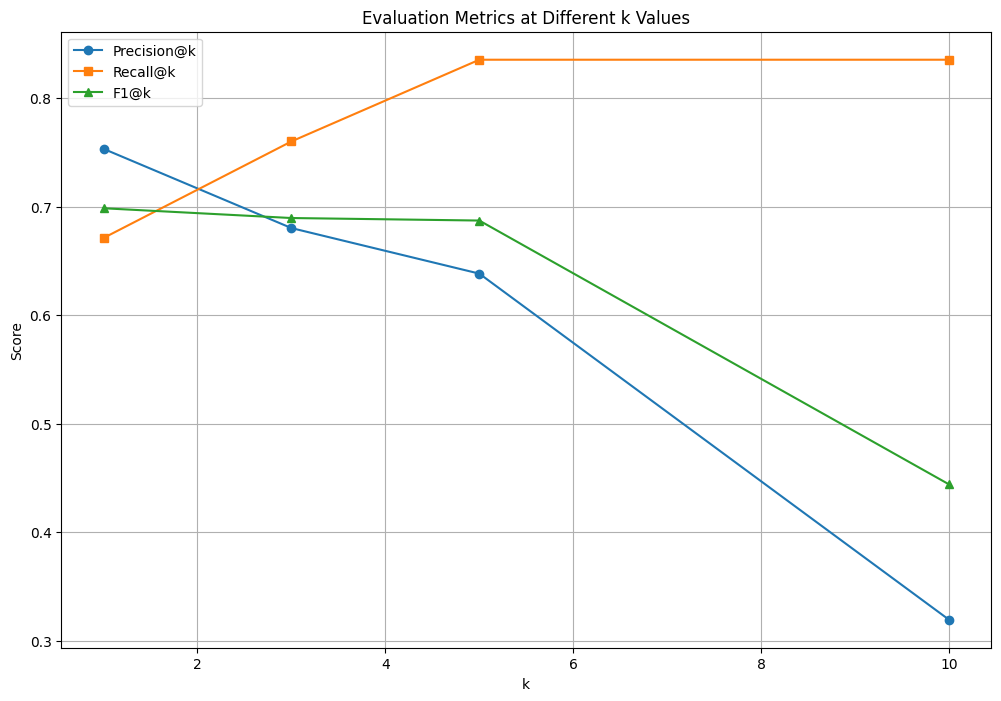


Analysis completed! Results saved to ./results/run_20250601_175730_all_text


In [4]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Compare change requests using SBERT embeddings and cosine similarity')
    
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/feature-data-comments-without-filename/preprocessed_feature_data_0.9.csv",
                        help='Path to the CSV data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample')
    
    # Token filtering parameters
    parser.add_argument('--token_std_threshold', type=float, default=3.0,
                        help='Standard deviation threshold for filtering token length outliers')
    parser.add_argument('--min_token_threshold', type=int, default=0,
                        help='Minimum token length threshold for filtering')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Batch size for generating embeddings')
    parser.add_argument('--training_epochs', type=int, default=30,
                        help='Number of epochs for SBERT fine-tuning (0 to skip)')
    parser.add_argument('--patience', type=int, default=5,
                        help='Early stopping patience (number of epochs to wait for improvement)')
    parser.add_argument('--top_k', type=int, default=5,
                        help='Number of similar requests to find for each test sample')
    
    args, unknown = parser.parse_known_args()
    results = main(args)